<a href="https://colab.research.google.com/github/vkaramanis/Coursera_Capstone/blob/main/The_Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let's assume that there is a small travel agency that wants to personalize its recommendations depending on the clients' preferences. This will enable the agency to understand how similar are different places and provide targeted suggestions to clients that have particular preferences.

Such a move will be beneficial for the clients too as they will have the opportunity to visit places that they most probably like rather than randomly visiting a place.

To do that we will use forthsquare's top picks for the 100 most popular destinations according to wikipedia [List_of_cities_by_international_visitors](https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors).

We will also need the coordinates of the cities, for that we will use the [Simple_maps](https://simplemaps.com/data/world-cities) dataset.

We will classify the cities based on the similarities they have on these top picks. Based on this classification we will find which are the key characteristics for each group of cities. This will enable us to provide targeted suggestions to future clients.


# Part 1
Load and clean data

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import folium
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

Download Top cities dataset

In [2]:
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

url = "https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')

In [3]:
table = soup.find("table")

parsed_data = []
for row in table.findAll('tr'):
  count = 0
  euromonitor = np.nan
  mastercard = np.nan
  city = np.nan
  country = np.nan
  arrivalsEuromonitor = np.nan
  arrivalsMastercard = np.nan
  growth = np.nan
  income = np.nan

  for td in row.findAll('td'):
    data = td.get_text(strip=True)
    if count%8 == 0:
      euromonitor = int(data) if data != "" else np.nan
    elif count%8 == 1:
      mastercard = int(data) if data != "" else np.nan
    elif count%8 == 2:
      city = data if data != "" else np.nan
    elif count%8 == 3:
      country = data if data != "" else np.nan
    elif count%8 == 4:
      arrivalsEuromonitor = int(data.replace(",","")) if data != "" else np.nan
    elif count%8 == 5:
      arrivalsMastercard = int(data.replace(",","")) if data != "" else np.nan
    elif count%8 == 6:
      growth = data if data != "" else np.nan
    elif count%8 == 7:
      income = float(data) if data != "" else np.nan

    count += 1
  parsed_data += [[euromonitor, mastercard, city, country, arrivalsEuromonitor, arrivalsMastercard, growth, income]]

columns = ['Rank (Euromonitor)',
           'Rank (Mastercard)',
           'City',
           'Country',
           'Arrivals 2018 (Euromonitor)',
           'Arrivals 2016 (Mastercard)',
           'Growth in arrivals (Euromonitor)',
           'Income (billions $) (Mastercard)']
top_cities = pd.DataFrame(parsed_data[1:], columns=columns)
top_cities.head()

,Rank (Euromonitor),Rank (Mastercard),City,Country,Arrivals 2018 (Euromonitor),Arrivals 2016 (Mastercard),Growth in arrivals (Euromonitor),Income (billions $) (Mastercard)
0,1.0,11.0,Hong Kong,Hong Kong,29262700.0,8370000.0,5.0%,6.84
1,2.0,1.0,Bangkok,Thailand,24177500.0,21470000.0,7.7%,14.84
2,3.0,2.0,London,United Kingdom,19233000.0,19880000.0,−3.0%,19.76
3,4.0,NaN,Macau,Macau,18931400.0,NaN,9.2%,NaN
4,5.0,6.0,Singapore,Singapore,18551200.0,12110000.0,5.3%,12.54


Remove unwanted columns

In [4]:
top_cities.drop(columns=['Rank (Euromonitor)',
                            'Rank (Mastercard)',
                            'Arrivals 2018 (Euromonitor)',
                            'Arrivals 2016 (Mastercard)',
                            'Growth in arrivals (Euromonitor)',
                            'Income (billions $) (Mastercard)'], inplace=True)
top_cities.head()

,City,Country
0,Hong Kong,Hong Kong
1,Bangkok,Thailand
2,London,United Kingdom
3,Macau,Macau
4,Singapore,Singapore


Download world cities dataset

In [5]:
world_cities = pd.read_csv('/content/worldcities.csv')
world_cities.drop(columns=['city_ascii', 'iso2', 'iso3', 'admin_name', 'capital', 'population', 'id'], inplace=True)
world_cities.head()

,city,lat,lng,country
0,Tokyo,35.6897,139.6922,Japan
1,Jakarta,-6.2146,106.8451,Indonesia
2,Delhi,28.6600,77.2300,India
3,Mumbai,18.9667,72.8333,India
4,Manila,14.6000,120.9833,Philippines


Merge the two datasets

In [6]:
top_cities = top_cities.merge(world_cities, left_on=['City', 'Country'], right_on=['city', 'country'], how='left')
top_cities.drop(columns=['city', 'country'], inplace=True)
top_cities.head()

,City,Country,lat,lng
0,Hong Kong,Hong Kong,22.3050,114.1850
1,Bangkok,Thailand,13.7500,100.5167
2,London,United Kingdom,51.5072,-0.1275
3,Macau,Macau,22.2030,113.5450
4,Singapore,Singapore,1.3000,103.8000


Check if all cities have coordinates

In [7]:
top_cities[top_cities.isna().any(axis=1)]

,City,Country,lat,lng
7,New York City,United States,NaN,NaN
17,Pattaya,Thailand,NaN,NaN
21,Prague,Czech Republic,NaN,NaN
23,Seoul,South Korea,NaN,NaN
25,Agra,India,NaN,NaN
28,Osaka,Japan,NaN,NaN
49,Ha Long,Vietnam,NaN,NaN
65,Dammam,Saudi Arabia,NaN,NaN
66,Penang Island,Malaysia,NaN,NaN
67,Heraklion,Greece,NaN,NaN


As we see some cities did not match with the world cities dataset. I will manually edit these entries.

In [8]:
coordinates = [['New York City', 40.712778, -74.006111],
                       ['Pattaya', 12.933333, 100.883333],
                       ['Prague', 50.083333, 14.416667],
                       ['Seoul', 37.56, 126.99],
                       ['Agra', 27.18, 78.02],
                       ['Osaka', 34.693889, 135.502222],
                       ['Ha Long', 20.95, 107.083333],
                       ['Jerusalem', 31.783333, 35.216667],
                       ['Dammam', 26.433333, 50.1],
                       ['Penang Island', 5.4025, 100.365],
                       ['Heraklion', 35.340278, 25.134444],
                       ['Kyoto', 35.011667, 135.768333],
                       ['Marrakesh', 31.63, -8.008889],
                       ['Kolkata', 22.5675, 88.37],
                       ['Tel Aviv', 32.066667, 34.783333],
                       ['Hurghada', 27.257778, 33.811667],
                       ['Frankfurt am Main', 50.116667, 8.683333],
                       ['Da Nang', 16.069444, 108.209722],
                       ['Batam', 1.083333, 104.033333],
                       ['Jeju', 33.50972, 126.52194],
                       ['Rhodes', 36.433333, 28.216667],
                       ['Punta Cana', 18.533333, -68.366667],
                       ['Montreal', 45.508889, -73.554167],
                       ['Washington D.C.', 38.9101, -77.0147],
                       ['Bogota', 4.711111, -74.072222],
                       ["Xi'an", 34.265, 108.954]]
for city in coordinates:
  top_cities.loc[top_cities['City']==city[0], 'lat'] = city[1]
  top_cities.loc[top_cities['City']==city[0], 'lng'] = city[2]
top_cities[top_cities.isna().any(axis=1)]


,City,Country,lat,lng


Foursquare credentials

In [9]:
CLIENT_ID = 'AOPRA1LBOND0SQ2PJTOBZECRI3LYF4ZR2XJXEAXQNMFLYIZJ'
CLIENT_SECRET = 'ZKOKZSCLPFXKKQLSNLBHCMGMIOAHWVLB2Q0RW2FXUA1CSSQE'
LIMIT = 50
SECTION = 'topPicks'
VERSION = '20210730'

Use provided function to find top picks from top countries

In [10]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            SECTION,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
top_venues = getNearbyVenues(names=top_cities['City'],
                                 latitudes=top_cities['lat'],
                                 longitudes=top_cities['lng'])

Hong Kong
Bangkok
London
Macau
Singapore
Paris
Dubai
New York City
Kuala Lumpur
Istanbul
Delhi
Antalya
Shenzhen
Mumbai
Phuket
Rome
Tokyo
Pattaya
Taipei
Mecca
Guangzhou
Prague
Medina
Seoul
Amsterdam
Agra
Miami
Miami
Osaka
Las Vegas
Las Vegas
Shanghai
Ho Chi Minh City
Denpasar
Barcelona
Los Angeles
Milan
Chennai
Vienna
Johor Bahru
Jaipur
Cancún
Berlin
Cairo
Athens
Orlando
Moscow
Venice
Madrid
Ha Long
Riyadh
Dublin
Florence
Hanoi
Toronto
Johannesburg
Sydney
Munich
Jakarta
Beijing
Saint Petersburg
Brussels
Jerusalem
Budapest
Lisbon
Dammam
Penang Island
Heraklion
Kyoto
Zhuhai
Vancouver
Chiang Mai
Copenhagen
San Francisco
Melbourne
Warsaw
Marrakesh
Kolkata
Cebu City
Auckland
Tel Aviv
Guilin
Honolulu
Hurghada
Kraków
Muğla
Buenos Aires
Chiba
Frankfurt am Main
Stockholm
Lima
Da Nang
Batam
Nice
Fukuoka
Abu Dhabi
Jeju
Porto
Rhodes
Rio de Janeiro
Krabi
Bangalore
Mexico City
Punta Cana
São Paulo
Zürich
Montreal
Washington D.C.
Chicago
Düsseldorf
Boston
Boston
Chengdu
Edinburgh
San Jose
Tehran
Houst

In [12]:
print(top_venues.shape)
top_venues.head()

(5207, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hong Kong,22.305,114.185,Scarlett Café & Wine Bar,22.302347,114.176632,French Restaurant
1,Hong Kong,22.305,114.185,Hong Kong Museum of History (香港歷史博物館),22.301474,114.177297,History Museum
2,Hong Kong,22.305,114.185,Hung Hom Promenade (紅磡海濱花園),22.300508,114.188247,Waterfront
3,Hong Kong,22.305,114.185,Tsong Long Ting (滄浪亭),22.307498,114.185562,Noodle House
4,Hong Kong,22.305,114.185,Zanhao TW (Zanhao TW 讚好台灣),22.305471,114.186301,Taiwanese Restaurant


one hot encoding

In [13]:
# one hot encoding
onehot = pd.get_dummies(top_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['City'] = top_venues['City'] 

# move neighborhood column to the first column
columns = list(onehot.columns)
columns.remove('City')
fixed_columns = ['City'] + columns
onehot = onehot[fixed_columns]

onehot.head()

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Awadhi Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Balinese Restaurant,Bar,Basketball Court,Bath House,Bavarian Restaurant,Bay,Beach,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,Betawinese Restaurant,Betting Shop,Big Box Store,Bistro,...,Tapas Restaurant,Taverna,Tea Room,Teishoku Restaurant,Tempura Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tonkatsu Restaurant,Tour Provider,Toy / Game Store,Track,Trail,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Wagashi Place,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zhejiang Restaurant
0,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
grouped = onehot.groupby('City').mean().reset_index()
grouped

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Awadhi Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Balinese Restaurant,Bar,Basketball Court,Bath House,Bavarian Restaurant,Bay,Beach,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,Betawinese Restaurant,Betting Shop,Big Box Store,Bistro,...,Tapas Restaurant,Taverna,Tea Room,Teishoku Restaurant,Tempura Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tonkatsu Restaurant,Tour Provider,Toy / Game Store,Track,Trail,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Wagashi Place,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zhejiang Restaurant
0,Abu Dhabi,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.060000,0.0,0.000000,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.02,0.000000,0.00,0.00,0.0,0.0
1,Accra,0.0,0.0,0.0,0.04,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.040000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.02,0.00,0.0,0.0
2,Agra,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.032258,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032258,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.00,0.0,0.0
3,Amman,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.052632,0.0,0.026316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.026316,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.000000,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.026316,0.00,0.00,0.0,0.0
4,Amsterdam,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.020000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.020000,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.04,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Washington D.C.,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.00,0.0,0.0
136,Xi'an,0.0,0.0,0.0,0.00,0.043478,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0

Use provided function to find the top most cummon venues of each city

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = grouped['City']

for ind in np.arange(grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abu Dhabi,Middle Eastern Restaurant,Indian Restaurant,Coffee Shop,Bakery,Dessert Shop,Gym,Clothing Store,French Restaurant,Café,Chinese Restaurant
1,Accra,Nightclub,Café,Restaurant,Cocktail Bar,Italian Restaurant,African Restaurant,Shopping Mall,Bakery,Chinese Restaurant,Department Store
2,Agra,Indian Restaurant,Hotel,Multicuisine Indian Restaurant,Market,Italian Restaurant,Indian Sweet Shop,Bistro,South Indian Restaurant,Mughlai Restaurant,Arts & Crafts Store
3,Amman,Café,Coffee Shop,Ice Cream Shop,Dessert Shop,Breakfast Spot,Middle Eastern Restaurant,Park,Art Gallery,Falafel Restaurant,Music Venue
4,Amsterdam,Coffee Shop,Sandwich Place,Breakfast Spot,Café,Canal,Clothing Store,Creperie,Shopping Mall,Restaurant,Hotel


# Part 2

Clustering and final analysis 

Find optimal k

In [17]:
clustering = grouped.drop('City', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(clustering)
    Sum_of_squared_distances.append(km.inertia_)

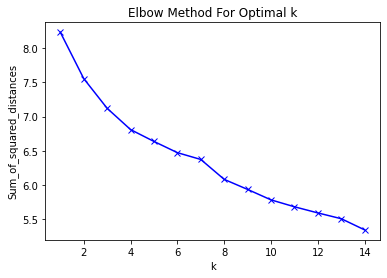

In [18]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

There is no clear Elbow but k=7 pops out from the rest

In [22]:
# set number of clusters
kclusters = 7
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 4, 2, 5, 1, 2, 1, 3, 4], dtype=int32)

In [24]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
merged = top_cities
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
merged = merged.join(cities_venues_sorted.set_index('City'), on='City')

merged.head() # check the last columns!

,City,Country,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,Hong Kong,22.3050,114.1850,3,Japanese Restaurant,Café,Chinese Restaurant,Hotel Bar,Pool,Jewelry Store,Noodle House,Market,Steakhouse,Roof Deck
1,Bangkok,Thailand,13.7500,100.5167,1,Chinese Restaurant,Noodle House,Thai Restaurant,Japanese Curry Restaurant,Video Store,Music Venue,Gym / Fitness Center,Soup Place,Som Tum Restaurant,Massage Studio
2,London,United Kingdom,51.5072,-0.1275,5,Coffee Shop,Plaza,Outdoor Sculpture,Garden,Bakery,Park,Sculpture Garden,Seafood Restaurant,Gourmet Shop,Wine Bar
3,Macau,Macau,22.2030,113.5450,2,Café,Portuguese Restaurant,Park,Dessert Shop,Plaza,History Museum,Coffee Shop,Cantonese Restaurant,Macanese Restaurant,Track
4,Singapore,Singapore,1.3000,103.8000,2,Food Court,Café,Basketball Court,Dessert Shop,Park,Betting Shop,Malay Restaurant,Salad Place,Asian Restaurant,Indian Restaurant


Locate the different clusters on the map

In [25]:
# create map
map_clusters = folium.Map(location=[0, 0], zoom_start= 2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['lat'], merged['lng'], merged['City'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We see that there is a logical distinction between the clusters.

For clarity i will provide the cities of each cluster and its top 10 characteristics

In [50]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Rome,Plaza,Italian Restaurant,Café,Coffee Shop,Fountain,Pizza Place,Restaurant,Sandwich Place,Bakery,History Museum
34,Barcelona,Plaza,Tapas Restaurant,Spanish Restaurant,Dessert Shop,Coffee Shop,Mediterranean Restaurant,Market,Café,Pedestrian Plaza,Hotel Bar
36,Milan,Plaza,Café,Bakery,Boutique,Dessert Shop,Ice Cream Shop,Sporting Goods Shop,Bistro,Furniture / Home Store,Clothing Store
42,Berlin,Plaza,Coffee Shop,Gourmet Shop,Gym,Bistro,Organic Grocery,Sandwich Place,Café,Italian Restaurant,Beer Garden
46,Moscow,Plaza,Boutique,Fountain,History Museum,Coffee Shop,Italian Restaurant,Shoe Store,Clothing Store,Park,Bistro
47,Venice,Plaza,Bakery,Italian Restaurant,Art Museum,Café,Restaurant,Hotel,Theater,Ice Cream Shop,Museum
48,Madrid,Plaza,Spanish Restaurant,Garden,Ice Cream Shop,Park,Gastropub,Cocktail Bar,Café,Brewery,Bookstore
52,Florence,Plaza,Café,Museum,Ice Cream Shop,Italian Restaurant,Coffee Shop,Art Museum,Boutique,Bar,Lounge
88,Frankfurt am Main,Plaza,Park,Coffee Shop,Café,Bakery,Pedestrian Plaza,Indie Movie Theater,Bistro,Fountain,Gym / Fitness Center
89,Stockholm,Plaza,Hotel,Café,Bakery,Modern European Restaurant,Art Gallery,BBQ Joint,Scandinavian Restaurant,Harbor / Marina,Gym


In [49]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bangkok,Chinese Restaurant,Noodle House,Thai Restaurant,Japanese Curry Restaurant,Video Store,Music Venue,Gym / Fitness Center,Soup Place,Som Tum Restaurant,Massage Studio
11,Antalya,Department Store,Auto Garage,Motorcycle Shop,Turkish Restaurant,Auto Workshop,Gym,Arts & Crafts Store,Park,Garden Center,Bath House
26,Miami,Latin American Restaurant,Nightclub,Café,Smoke Shop,Record Shop,Coffee Shop,Liquor Store,Trail,Construction & Landscaping,Sporting Goods Shop
27,Miami,Latin American Restaurant,Nightclub,Café,Smoke Shop,Record Shop,Coffee Shop,Liquor Store,Trail,Construction & Landscaping,Sporting Goods Shop
29,Las Vegas,American Restaurant,Mexican Restaurant,Pizza Place,Golf Course,Park,Health & Beauty Service,Tea Room,Taco Place,Burger Joint,Food Truck
30,Las Vegas,American Restaurant,Mexican Restaurant,Pizza Place,Golf Course,Park,Health & Beauty Service,Tea Room,Taco Place,Burger Joint,Food Truck
31,Shanghai,Art Gallery,Shopping Mall,Park,Chinese Restaurant,Bakery,Concert Hall,Skate Park,Antique Shop,Movie Theater,Art Museum
35,Los Angeles,Scenic Lookout,Hotel,Music Venue,Hotel Bar,Bar,Park,Plaza,Diner,Comedy Club,Rock Club
41,Cancún,Mexican Restaurant,Taco Place,Sushi Restaurant,Seafood Restaurant,Food Truck,Furniture / Home Store,Gift Shop,Health & Beauty Service,Pharmacy,BBQ Joint
45,Orlando,Record Shop,Deli / Bodega,Motorcycle Shop,Basketball Court,Caribbean Restaurant,German Restaurant,Friterie,Food & Drink Shop,Food Court,Food Service


In [51]:
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Macau,Café,Portuguese Restaurant,Park,Dessert Shop,Plaza,History Museum,Coffee Shop,Cantonese Restaurant,Macanese Restaurant,Track
4,Singapore,Food Court,Café,Basketball Court,Dessert Shop,Park,Betting Shop,Malay Restaurant,Salad Place,Asian Restaurant,Indian Restaurant
9,Istanbul,Café,Clothing Store,Women's Store,Restaurant,Gym,Hotel,Shoe Store,Department Store,Boutique,Steakhouse
18,Taipei,Café,Japanese Restaurant,Electronics Store,Taiwanese Restaurant,Coffee Shop,Hotpot Restaurant,Asian Restaurant,Noodle House,Dessert Shop,Snack Place
21,Prague,Café,Plaza,Coffee Shop,Gym,History Museum,Outdoor Sculpture,Paper / Office Supplies Store,Palace,Mini Golf,Chocolate Shop
28,Osaka,Café,Coffee Shop,Japanese Curry Restaurant,Bakery,Whisky Bar,Sake Bar,Beer Garden,Pastry Shop,Beer Bar,BBQ Joint
38,Vienna,Café,Plaza,Restaurant,Bakery,Austrian Restaurant,History Museum,Pedestrian Plaza,Coffee Shop,Tea Room,Clothing Store
43,Cairo,Café,Lounge,Dessert Shop,Italian Restaurant,Hotel Bar,Market,Sports Club,Bookstore,Plaza,Coffee Shop
44,Athens,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Electronics Store,Dessert Shop,Grilled Meat Restaurant,Bar,Theater,Kafenio,Health Food Store
51,Dublin,Café,Coffee Shop,Supermarket,Plaza,Breakfast Spot,Sushi Restaurant,Park,Outdoor Sculpture,Scenic Lookout,Grocery Store


In [52]:
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,Japanese Restaurant,Café,Chinese Restaurant,Hotel Bar,Pool,Jewelry Store,Noodle House,Market,Steakhouse,Roof Deck
6,Dubai,Café,Middle Eastern Restaurant,Restaurant,Shopping Mall,Coffee Shop,Indian Restaurant,Art Gallery,Asian Restaurant,Plaza,Farmers Market
12,Shenzhen,Shopping Mall,Café,Park,Hong Kong Restaurant,Cantonese Restaurant,Japanese Restaurant,Department Store,Cha Chaan Teng,Supermarket,Gym / Fitness Center
17,Pattaya,Clothing Store,BBQ Joint,Ice Cream Shop,Thai Restaurant,Hotpot Restaurant,Multiplex,Bakery,Pub,Dessert Shop,Japanese Restaurant
19,Mecca,Restaurant,Shopping Mall,Cosmetics Shop,Middle Eastern Restaurant,Supermarket,Clothing Store,Breakfast Spot,Convenience Store,Mountain,Trail
20,Guangzhou,Chinese Restaurant,Shopping Mall,History Museum,Thai Restaurant,Dessert Shop,Park,Fast Food Restaurant,Bar,Outdoor Sculpture,Clothing Store
22,Medina,Café,Breakfast Spot,Coffee Shop,Middle Eastern Restaurant,History Museum,Shopping Mall,Falafel Restaurant,Department Store,Ice Cream Shop,Seafood Restaurant
32,Ho Chi Minh City,Café,Coffee Shop,Shopping Mall,Japanese Restaurant,Seafood Restaurant,BBQ Joint,Grocery Store,Sushi Restaurant,Supermarket,Movie Theater
33,Denpasar,Asian Restaurant,ATM,Chinese Restaurant,Balinese Restaurant,Cosmetics Shop,Food & Drink Shop,Food Court,Shopping Mall,Snack Place,Vape Store
39,Johor Bahru,Café,Bakery,Clothing Store,Coffee Shop,Ice Cream Shop,Noodle House,Boutique,Shopping Mall,Chinese Restaurant,Dessert Shop


In [53]:
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Kuala Lumpur,Indian Restaurant,Chinese Restaurant,Food Truck,Café,Dessert Shop,Vegetarian / Vegan Restaurant,Bakery,Malay Restaurant,Noodle House,Flower Shop
10,Delhi,Indian Restaurant,Café,Chinese Restaurant,Flea Market,Lounge,Donut Shop,Bakery,Snack Place,Molecular Gastronomy Restaurant,Tibetan Restaurant
13,Mumbai,Indian Restaurant,Dessert Shop,Bakery,Restaurant,Harbor / Marina,Movie Theater,Department Store,Gym,Ice Cream Shop,History Museum
25,Agra,Indian Restaurant,Hotel,Multicuisine Indian Restaurant,Market,Italian Restaurant,Indian Sweet Shop,Bistro,South Indian Restaurant,Mughlai Restaurant,Arts & Crafts Store
37,Chennai,Indian Restaurant,Vegetarian / Vegan Restaurant,Café,Sandwich Place,Farmers Market,Dessert Shop,Middle Eastern Restaurant,Fast Food Restaurant,Bakery,Donut Shop
40,Jaipur,Indian Restaurant,Café,Bakery,Palace,Shopping Mall,Restaurant,Tea Room,Market,Bookstore,Movie Theater
54,Toronto,Sushi Restaurant,Steakhouse,Burger Joint,Turkish Restaurant,Indian Restaurant,Pizza Place,Mediterranean Restaurant,Japanese Restaurant,Italian Restaurant,Food Court
101,Bangalore,Indian Restaurant,Lounge,Breakfast Spot,Pub,Café,Ice Cream Shop,Italian Restaurant,Chinese Restaurant,Fast Food Restaurant,Bookstore
135,Pune,Indian Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Seafood Restaurant,Café,Burger Joint,Maharashtrian Restaurant,Snack Place,Restaurant,Tea Room


In [54]:
merged.loc[merged['Cluster Labels'] == 5, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,London,Coffee Shop,Plaza,Outdoor Sculpture,Garden,Bakery,Park,Sculpture Garden,Seafood Restaurant,Gourmet Shop,Wine Bar
5,Paris,Café,Plaza,French Restaurant,Coffee Shop,Bakery,Italian Restaurant,Ice Cream Shop,Park,Pedestrian Plaza,History Museum
7,New York City,Ice Cream Shop,Café,Park,Pizza Place,Coffee Shop,Restaurant,Italian Restaurant,Gay Bar,Fountain,Flower Shop
14,Phuket,Coffee Shop,Thai Restaurant,Café,Noodle House,Park,Chinese Restaurant,Bookstore,Restaurant,Tea Room,Snack Place
23,Seoul,Korean Restaurant,Coffee Shop,Noodle House,Italian Restaurant,Café,Bar,Vietnamese Restaurant,Outdoor Sculpture,Park,Bistro
24,Amsterdam,Coffee Shop,Sandwich Place,Breakfast Spot,Café,Canal,Clothing Store,Creperie,Shopping Mall,Restaurant,Hotel
50,Riyadh,Breakfast Spot,Coffee Shop,Fast Food Restaurant,Bakery,Restaurant,Asian Restaurant,History Museum,Donut Shop,Supermarket,Shoe Store
55,Johannesburg,Coffee Shop,Café,Art Gallery,Shopping Mall,Bistro,Breakfast Spot,Theater,Asian Restaurant,Lounge,Bar
58,Jakarta,Betawinese Restaurant,Padangnese Restaurant,Electronics Store,Food Truck,Fried Chicken Joint,Indonesian Restaurant,Coffee Shop,Music Venue,Rock Club,Gay Bar
59,Beijing,Coffee Shop,Chinese Restaurant,Café,History Museum,Tea Room,Shopping Plaza,Bookstore,Scenic Lookout,Park,Concert Hall


In [55]:
merged.loc[merged['Cluster Labels'] == 6, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Tokyo,Camera Store,Ramen Restaurant,Café,Udon Restaurant,Hotel Bar,Italian Restaurant,Scenic Lookout,Public Art,Buffet,Chinese Restaurant
87,Chiba,Ramen Restaurant,Supermarket,Café,Electronics Store,Bookstore,Used Bookstore,Waterfront,Scenic Lookout,Seafood Restaurant,Convenience Store
94,Fukuoka,Japanese Restaurant,Park,BBQ Joint,Ramen Restaurant,Café,Soba Restaurant,Deli / Bodega,Sake Bar,Udon Restaurant,Unagi Restaurant
